In [ ]:
#Importar las librerias necesarias
import geopandas as gpd
import numpy as np
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import time
import zipfile
import warnings
import os
import tempfile
import shutil
import matplotlib.pyplot as plt
import seaborn as sns


**Porcentaje de agua residual generada que es tratada en Ciudad de México**

In [5]:
#Establecer directorio temporal de trabajo
os.create_tempdir = True
if os.create_tempdir:
    temp_dir = os.path.join(os.getcwd(), "temp")
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    os.chdir(temp_dir)


In [6]:
# Descargar y descomprimir el chromedriver
url = "https://storage.googleapis.com/chrome-for-testing-public/137.0.7151.68/win64/chromedriver-win64.zip" #Esta ruta cambia dependiendo de tu versión de google chrome
zip_path = "chromedriver-win64.zip"
extract_path = "chromedriver-win64"

response = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(response.content)
    
if zipfile.is_zipfile(zip_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    os.remove(zip_path) 

webdriver_path = r'chromedriver-win64\chromedriver-win64\chromedriver.exe'
options = webdriver.ChromeOptions()
options.add_argument('headless=False')
options.add_argument('--disable-gpu')
service = Service(webdriver_path)
driver = webdriver.Chrome(service=service, options=options)

In [ ]:
# Crear un directorio temporal
descarga_dir = tempfile.mkdtemp()

# Configurar Chrome para permitir descargas sin preguntar
chrome_options = Options()
prefs = {
    "download.default_directory": descarga_dir,
    "download.prompt_for_download": False,
    "download.directory_upgrade": True,
    "safebrowsing.enabled": True,
    "profile.default_content_setting_values.automatic_downloads": 1,
    "profile.content_settings.exceptions.automatic_downloads.*.setting": 1
}
chrome_options.add_experimental_option("prefs", prefs)

# Inicializar el navegador
driver = webdriver.Chrome(options=chrome_options)

# Abrir la URL
url = "http://dgeiawf.semarnat.gob.mx:8080/ibi_apps/WFServlet?IBIF_ex=D3_AGUA07_15&IBIC_user=c24&IBIC_pass=c24"
driver.get(url)

# Esperar a que cargue y dar clic al botón de Excel
driver.implicitly_wait(10)
driver.find_element(By.CSS_SELECTOR, 'input[title="Reporte Excel"]').click()

# Esperar a que se descargue el archivo (espera activa hasta que termine la descarga)
archivo_descargado = None
tiempo_max_espera = 60
inicio = time.time()
while time.time() - inicio < tiempo_max_espera:
    archivos = os.listdir(descarga_dir)
    xls_files = [f for f in archivos if f.endswith(".xlsx") or f.endswith(".xls")]
    time.sleep(1)
# Cerrar el navegador
driver.quit()


Nota: antes de abrir el archivo aqui, se renombra abriendolo en excel como agua_residual_generada_colectada_tratada.xlsx

In [132]:
ruta_completa = os.path.join(descarga_dir, "agua_residual_generada_colectada_tratada.xlsx")


In [136]:
# Lee el archivo Excel
df = pd.read_excel(ruta_completa, 
skiprows=3)
df.columns = (
    df.columns.str.strip()
              .str.lower() 
              .str.replace(" ", "_")
              .str.replace(r"[^\w_]", "", regex=True)
)

agua_tratada = agua_tratada[['año', 'agua_residual_generada', 'agua_residual_tratada']]
agua_tratada['Entidad'] = 'Ciudad de México'
agua_tratada['porcentaje_tratado'] = agua_tratada['agua_residual_tratada'] * 100 / agua_tratada['agua_residual_generada']
print(agua_tratada)


     año  agua_residual_generada  agua_residual_tratada           Entidad  \
32  2019                   23.15                  18.64  Ciudad de México   
33  2020                   26.08                  19.68  Ciudad de México   
34  2021                   26.08                  19.72  Ciudad de México   
35  2022                   25.21                  20.99  Ciudad de México   

    porcentaje_tratado  
32           80.518359  
33           75.460123  
34           75.613497  
35           83.260611  


In [137]:
# Filtra años inicial y final para calcular TCMA
df_inicial = agua_tratada[agua_tratada['año'] == 2019].set_index('Entidad')
df_final = agua_tratada[agua_tratada['año'] == 2022].set_index('Entidad')

# Combinar para tener porcentaje inicial y final juntos
df_comb = df_inicial[['porcentaje_tratado']].rename(columns={'porcentaje_tratado': 'p1'}).join(
    df_final[['porcentaje_tratado']].rename(columns={'porcentaje_tratado': 'p2'}))

# Calcular TCMA para cada entidad (asegurando no dividir por cero ni valores negativos)
df_comb['TCMA'] = (df_comb['p2'] / df_comb['p1']) ** (1 / (2022 - 2019)) - 1

# Año base y TCMA 2022
valor_base = df_comb['p2']
tcma = df_comb['TCMA']

# Definir los años a proyectar
años_proyectar = [2030, 2035, 2045]

# Crear listas para guardar resultados (estructura larga)
años_resultado = []
porcentaje_resultado = []
tipo_resultado = []

# Calcular las proyecciones (total por año)
for año in años_proyectar:
    # Inercial
    total_inercial = (valor_base * (1 + 1/4 * tcma) ** (año - 2022)).sum()
    años_resultado.append(año)
    porcentaje_resultado.append(total_inercial)
    tipo_resultado.append("Inercial")
    
    # Deseable
    total_deseable = (valor_base * (1 + 1/3 * tcma) ** (año - 2022)).sum()
    años_resultado.append(año)
    porcentaje_resultado.append(total_deseable)
    tipo_resultado.append("Deseable")
    
    # Transformador
    total_transformador = (valor_base * (1 + 1/2 * tcma) ** (año - 2022)).sum()
    años_resultado.append(año)
    porcentaje_resultado.append(total_transformador)
    tipo_resultado.append("Transformador")

# Crear un DataFrame largo con todos los escenarios
df_años = pd.DataFrame({
    'año': años_resultado,
    'porcentaje_tratado': porcentaje_resultado,
    'Tipo': tipo_resultado
})

# Pegar los resultados al DataFrame original (opcional)
agua_tratada_base = agua_tratada[['año', 'porcentaje_tratado']].copy()
agua_tratada_base['Tipo'] = "Observado"

# Concatenar históricos + escenarios
agua_tratada_final = pd.concat([agua_tratada_base, df_años], ignore_index=True)

# Mostrar el DataFrame final
print(agua_tratada_final)


     año  porcentaje_tratado           Tipo
0   2019           80.518359      Observado
1   2020           75.460123      Observado
2   2021           75.613497      Observado
3   2022           83.260611      Observado
4   2030           85.148444       Inercial
5   2030           85.785990       Deseable
6   2030           87.073624  Transformador
7   2035           86.350015       Inercial
8   2035           87.403103       Deseable
9   2035           89.544933  Transformador
10  2045           88.804263       Inercial
11  2045           90.729354       Deseable
12  2045           94.699962  Transformador


In [139]:
# Primero extraemos los valores necesarios
# Valor Observado en 2022
observado_2022 = agua_tratada_final.loc[(agua_tratada_final['año'] == 2022) & (agua_tratada_final['Tipo'] == 'Observado'),'porcentaje_tratado'].values[0]
inercial_2030 = agua_tratada_final.loc[(agua_tratada_final['año'] == 2030) & (agua_tratada_final['Tipo'] == 'Inercial'),'porcentaje_tratado'].values[0]
deseable_2030 = agua_tratada_final.loc[(agua_tratada_final['año'] == 2030) & (agua_tratada_final['Tipo'] == 'Deseable'),'porcentaje_tratado'].values[0]
transformador_2030 = agua_tratada_final.loc[(agua_tratada_final['año'] == 2030) & (agua_tratada_final['Tipo'] == 'Transformador'),'porcentaje_tratado'].values[0]

# Crear data frame para las líneas y unirlas a las graficas
df_inercial = pd.DataFrame({'año': [2022, 2030],'porcentaje_tratado': [observado_2022, inercial_2030],'Tipo': ['Inercial', 'Inercial']})
df_deseable = pd.DataFrame({'año': [2022, 2030],'porcentaje_tratado': [observado_2022, deseable_2030],'Tipo': ['Deseable', 'Deseable']})
df_transformador = pd.DataFrame({'año': [2022, 2030],'porcentaje_tratado': [observado_2022, transformador_2030],'Tipo': ['Transformador', 'Transformador']})

lineas = pd.concat([df_inercial, df_deseable, df_transformador], ignore_index=True)
# Resultado
print(lineas)

    año  porcentaje_tratado           Tipo
0  2022           83.260611       Inercial
1  2030           85.148444       Inercial
2  2022           83.260611       Deseable
3  2030           85.785990       Deseable
4  2022           83.260611  Transformador
5  2030           87.073624  Transformador


In [140]:
# Paleta de colores
paleta_colores = {
    'Observado': '#9F2241',
    'Inercial': '#cfcfcf',
    'Deseable': '#027A35',
    'Transformador': '#AC6D14'}

# Tipos de línea
linetypes = {
    'Observado': 'solid',
    'Inercial': 'dashdot',
    'Deseable': 'dashdot',
    'Transformador': 'dashdot'}

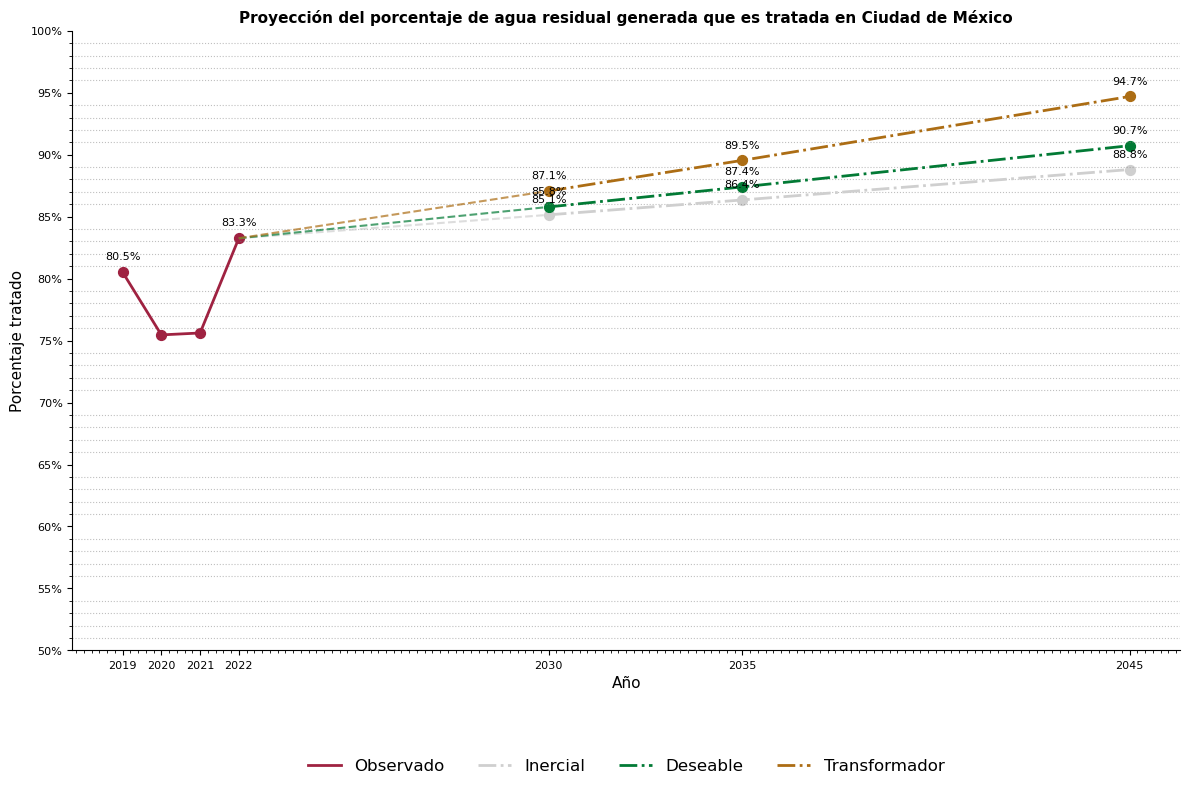

In [141]:
# Crear la figura
plt.figure(figsize=(12, 8))

# Graficar las series principales
for tipo in agua_tratada_final['Tipo'].unique():
    df_plot = agua_tratada_final[agua_tratada_final['Tipo'] == tipo]
    plt.plot(df_plot['año'], df_plot['porcentaje_tratado'],
             label=tipo,
             color=paleta_colores[tipo],
             linestyle=linetypes[tipo],
             linewidth=2)
    
    # Añadir puntos
    plt.scatter(df_plot['año'], df_plot['porcentaje_tratado'],
                color=paleta_colores[tipo], s=50)

    # Añadir etiquetas en puntos clave
    for x, y in zip(df_plot['año'], df_plot['porcentaje_tratado']):
        if x in [2019, 2022, 2030, 2035, 2045]:
            plt.text(x, y + 1, f"{y:.1f}%", ha='center', fontsize=8, fontfamily='sans-serif')

# Graficar las líneas auxiliares
for tipo in ['Inercial', 'Deseable', 'Transformador']:
    df_linea = lineas[lineas['Tipo'] == tipo]
    plt.plot(df_linea['año'], df_linea['porcentaje_tratado'],
             color=paleta_colores[tipo],
             linestyle='dashed',
             linewidth=1.5,
             alpha=0.7)

# Ejes
plt.xticks(agua_tratada_final['año'].unique(), fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel("Porcentaje tratado", fontsize=11)
plt.xlabel("Año", fontsize=11)
plt.title("Proyección del porcentaje de agua residual generada que es tratada en Ciudad de México", fontsize=11, fontweight='bold')

# Eje Y: que empiece en 50
y_max = agua_tratada_final['porcentaje_tratado'].max()
plt.ylim(50, y_max + 5)

# Etiquetas de porcentaje en eje Y
plt.yticks(ticks=range(50, int(y_max) + 10, 5), 
           labels=[f"{i}%" for i in range(50, int(y_max) + 8, 5)])

# Añadir leyenda abajo, fuera del gráfico
plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fontsize=12, ncol=4, frameon=False)

# Personalizar la rejilla
plt.grid(axis='y', which='minor', linestyle=':', color='gray', alpha=0.5)
plt.minorticks_on()
sns.despine()

# Mostrar gráfico
plt.tight_layout()
plt.show()
